In [1]:
# import the necessary libraries
import math
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# displays output inline
%matplotlib inline

## Data Processing

In [3]:
# authorize Colab to access Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [114]:
df_raw = pd.read_csv('/content/drive/MyDrive/fake_job_postings.csv')
# df_raw = pd.read_csv('/content/drive/Shared drives/758T Project/fake_job_postings.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [115]:
y = df_raw['fraudulent']
df_raw.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [116]:
import re
df_location = df_raw['location'].astype(str)
df_location = df_location.str.extract('(?P<Country>.+)\s*,\s*(?P<State>.+)\s*,\s*(?P<City>.+)', expand=True)        
df_location.head(10)

,Country,State,City
0,US,NY,New York
1,NZ,,Auckland
2,US,IA,Wever
3,US,DC,Washington
4,US,FL,Fort Worth
5,US,MD,
6,DE,BE,Berlin
7,US,CA,San Francisco
8,US,FL,Pensacola
9,US,AZ,Phoenix


In [117]:
df_salary_empty = df_raw['salary_range'].isnull().map({True:0,False:1})
# print(df_salary_empty[:10])
df_salary = df_raw['salary_range'].astype(str)
df_salary = df_salary.str.extract('(?P<Lower_Bound>\d+)\s*-\s*(?P<Upper_Bound>\d+)', expand=True)   
df_salary['salary_available'] = df_salary_empty
df_salary['Lower_Bound'] = df_salary['Lower_Bound'].astype(float)
df_salary['Upper_Bound'] = df_salary['Upper_Bound'].astype(float)
df_salary.head(10)

,Lower_Bound,Upper_Bound,salary_available
0,NaN,NaN,0
1,NaN,NaN,0
2,NaN,NaN,0
3,NaN,NaN,0
4,NaN,NaN,0
5,NaN,NaN,0
6,20000.0,28000.0,1
7,NaN,NaN,0
8,NaN,NaN,0
9,NaN,NaN,0


In [139]:
df = df_raw.drop(['job_id', 'location','salary_range'], axis = 1)
df = pd.concat([df,df_location,df_salary],axis = 1, join='inner')
df.describe()
#x.head()

,telecommuting,has_company_logo,has_questions,fraudulent,Lower_Bound,Upper_Bound,salary_available
count,17880.000000,17880.000000,17880.000000,17880.000000,2.841000e+03,2.841000e+03,17880.000000
mean,0.042897,0.795302,0.491723,0.048434,5.155773e+05,8.125715e+05,0.160403
std,0.202631,0.403492,0.499945,0.214688,1.769624e+07,2.705736e+07,0.366989
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.800000e+04,2.500000e+04,0.000000
50%,0.000000,1.000000,0.000000,0.000000,3.500000e+04,5.000000e+04,0.000000
75%,0.000000,1.000000,1.000000,0.000000,6.000000e+04,9.000000e+04,0.000000
max,1.000000,1.000000,1.000000,1.000000,8.000000e+08,1.200000e+09,1.000000


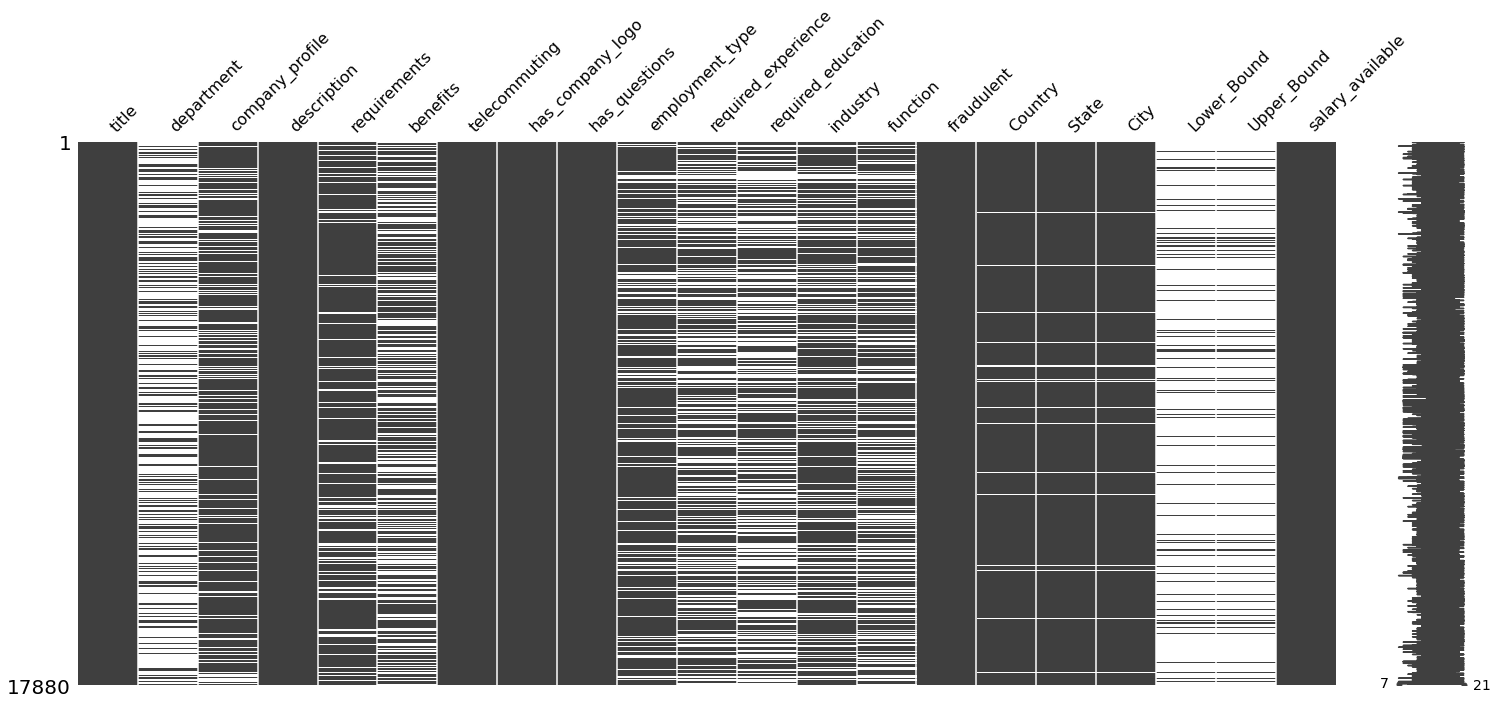

In [140]:
import missingno
missingno.matrix(df)

In [141]:
print(f"Unique values for department: {df['department'].nunique()}")
df['department'] = df['department'].fillna("nodepartment")

print(f"Unique values for company profile: {df['company_profile'].nunique()}")
df['company_profile'] = df['company_profile'].fillna("noprofile")

print(f"Unique values for requirements: {df['requirements'].nunique()}")
df['requirements'] = df['requirements'].fillna("norequirement")

print(f"Unique values for benefits: {df['benefits'].nunique()}")
df['benefits'] = df['benefits'].fillna("nobenefits")

print(f"Unique values for employment type: {df['employment_type'].nunique()}")
df['employment_type'] = df['employment_type'].fillna("noemptype")

print(f"Unique values for required experience: {df['required_experience'].nunique()}")
df['required_experience'] = df['required_experience'].fillna("noreqexp")

print(f"Unique values for required education: {df['required_education'].nunique()}")
df['required_education'] = df['required_education'].fillna("noreqedu")

print(f"Unique values for industry: {df['industry'].nunique()}")
df['industry'] = df['industry'].fillna("noindustry")

print(f"Unique values for function: {df['function'].nunique()}")
df['function'] = df['function'].fillna("nofunction")

df['description'] = df['description'].fillna("nodescription")
df['Country'] = df['Country'].fillna("nocountry")
df['State'] = df['State'].fillna("nostate")
df['City'] = df['City'].fillna("nocity")

Unique values for department: 1337
Unique values for company profile: 1709
Unique values for requirements: 11968
Unique values for benefits: 6205
Unique values for employment type: 5
Unique values for required experience: 7
Unique values for required education: 13
Unique values for industry: 131
Unique values for function: 37


In [142]:
df.isna().sum()

title                      0
department                 0
company_profile            0
description                0
requirements               0
benefits                   0
telecommuting              0
has_company_logo           0
has_questions              0
employment_type            0
required_experience        0
required_education         0
industry                   0
function                   0
fraudulent                 0
Country                    0
State                      0
City                       0
Lower_Bound            15039
Upper_Bound            15039
salary_available           0
dtype: int64

#### Numerical variables Normalization: *Lower_Bound, Upper_Bound*

In [143]:
df['Lower_Bound_Log'] = np.log10(df['Lower_Bound'].replace(0,1).fillna(0.1))
df['Upper_Bound_Log'] = np.log10(df['Upper_Bound'].replace(0,1).fillna(0.1))
df['Lower_Bound_Norm'] = (df['Lower_Bound_Log']-df['Lower_Bound_Log'].min())/(df['Lower_Bound_Log'].max()-df['Lower_Bound_Log'].min())
df['Upper_Bound_Norm'] = (df['Upper_Bound_Log']-df['Upper_Bound_Log'].min())/(df['Upper_Bound_Log'].max()-df['Upper_Bound_Log'].min())
df = df.drop(['Lower_Bound_Log', 'Upper_Bound_Log','Lower_Bound','Upper_Bound'], axis = 1)
df.describe()

,telecommuting,has_company_logo,has_questions,fraudulent,salary_available,Lower_Bound_Norm,Upper_Bound_Norm
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,0.042897,0.795302,0.491723,0.048434,0.160403,0.081487,0.083877
std,0.202631,0.403492,0.499945,0.214688,0.366989,0.195689,0.199763
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [144]:
categorical = []
for column in df.columns:
    if df[column].dtypes== 'int64' and column !='fraudulent':
       categorical.append(column)

categorical

['telecommuting', 'has_company_logo', 'has_questions', 'salary_available']

In [145]:
df_cat = df[categorical].copy()
df_cat['telecommuting'] = df_cat['telecommuting'].map({1:'havetelecommuting',0:'notelecommuting'})
df_cat['has_company_logo'] = df_cat['has_company_logo'].map({1:'havecompanylogo',0:'nocompanylogo'})
df_cat['has_questions'] = df_cat['has_questions'].map({1:'havequestions',0:'noquestions'})
df_cat['salary_available'] = df_cat['salary_available'].map({1:'salaryavailable',0:'salarynotavailable'})

In [146]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

encode_columns = ['employment_type','required_experience','required_education']
category_name = []
for column in encode_columns:
  category_name.append(list(df[column].value_counts().index))
  print(f"All possible {column}: {list(df[column].value_counts().index)}")

All possible employment_type: ['Full-time', 'noemptype', 'Contract', 'Part-time', 'Temporary', 'Other']
All possible required_experience: ['noreqexp', 'Mid-Senior level', 'Entry level', 'Associate', 'Not Applicable', 'Director', 'Internship', 'Executive']
All possible required_education: ['noreqedu', "Bachelor's Degree", 'High School or equivalent', 'Unspecified', "Master's Degree", 'Associate Degree', 'Certification', 'Some College Coursework Completed', 'Professional', 'Vocational', 'Some High School Coursework', 'Doctorate', 'Vocational - HS Diploma', 'Vocational - Degree']


In [147]:
encode_columns = ['employment_type','required_experience','required_education']
df_cat[encode_columns] = df[encode_columns].copy()

le = preprocessing.LabelEncoder()
for x in encode_columns:
  df[x]=le.fit_transform(df[x].astype(str))
  
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title                17880 non-null  object 
 1   department           17880 non-null  object 
 2   company_profile      17880 non-null  object 
 3   description          17880 non-null  object 
 4   requirements         17880 non-null  object 
 5   benefits             17880 non-null  object 
 6   telecommuting        17880 non-null  int64  
 7   has_company_logo     17880 non-null  int64  
 8   has_questions        17880 non-null  int64  
 9   employment_type      17880 non-null  int64  
 10  required_experience  17880 non-null  int64  
 11  required_education   17880 non-null  int64  
 12  industry             17880 non-null  object 
 13  function             17880 non-null  object 
 14  fraudulent           17880 non-null  int64  
 15  Country              17880 non-null 

In [148]:
category_index = []
for column in encode_columns:
  category_index.append(list(df[column].value_counts().index))
  print(f"All possible {column}: {list(df[column].value_counts().index)}")

All possible employment_type: [1, 5, 0, 3, 4, 2]
All possible required_experience: [7, 5, 2, 0, 6, 1, 4, 3]
All possible required_education: [13, 1, 4, 9, 5, 0, 2, 7, 6, 10, 8, 3, 12, 11]


In [150]:
name_list = []
for row in range(len(category_index)):
  category_dict = {}
  for column in range(len(category_index[row])):
    category_dict[category_name[row][column]] = category_index[row][column]
  name_list.append(category_dict)
name_list

[{'Contract': 0,
  'Full-time': 1,
  'Other': 2,
  'Part-time': 3,
  'Temporary': 4,
  'noemptype': 5},
 {'Associate': 0,
  'Director': 1,
  'Entry level': 2,
  'Executive': 3,
  'Internship': 4,
  'Mid-Senior level': 5,
  'Not Applicable': 6,
  'noreqexp': 7},
 {'Associate Degree': 0,
  "Bachelor's Degree": 1,
  'Certification': 2,
  'Doctorate': 3,
  'High School or equivalent': 4,
  "Master's Degree": 5,
  'Professional': 6,
  'Some College Coursework Completed': 7,
  'Some High School Coursework': 8,
  'Unspecified': 9,
  'Vocational': 10,
  'Vocational - Degree': 11,
  'Vocational - HS Diploma': 12,
  'noreqedu': 13}]

In [137]:
df_cat.head()

,telecommuting,has_company_logo,has_questions,salary_available,employment_type,required_experience,required_education
0,notelecommuting,havecompanylogo,noquestions,salarynotavailable,Other,Internship,noreqedu
1,notelecommuting,havecompanylogo,noquestions,salarynotavailable,Full-time,Not Applicable,noreqedu
2,notelecommuting,havecompanylogo,noquestions,salarynotavailable,noemptype,noreqexp,noreqedu
3,notelecommuting,havecompanylogo,noquestions,salarynotavailable,Full-time,Mid-Senior level,Bachelor's Degree
4,notelecommuting,havecompanylogo,havequestions,salarynotavailable,Full-time,Mid-Senior level,Bachelor's Degree


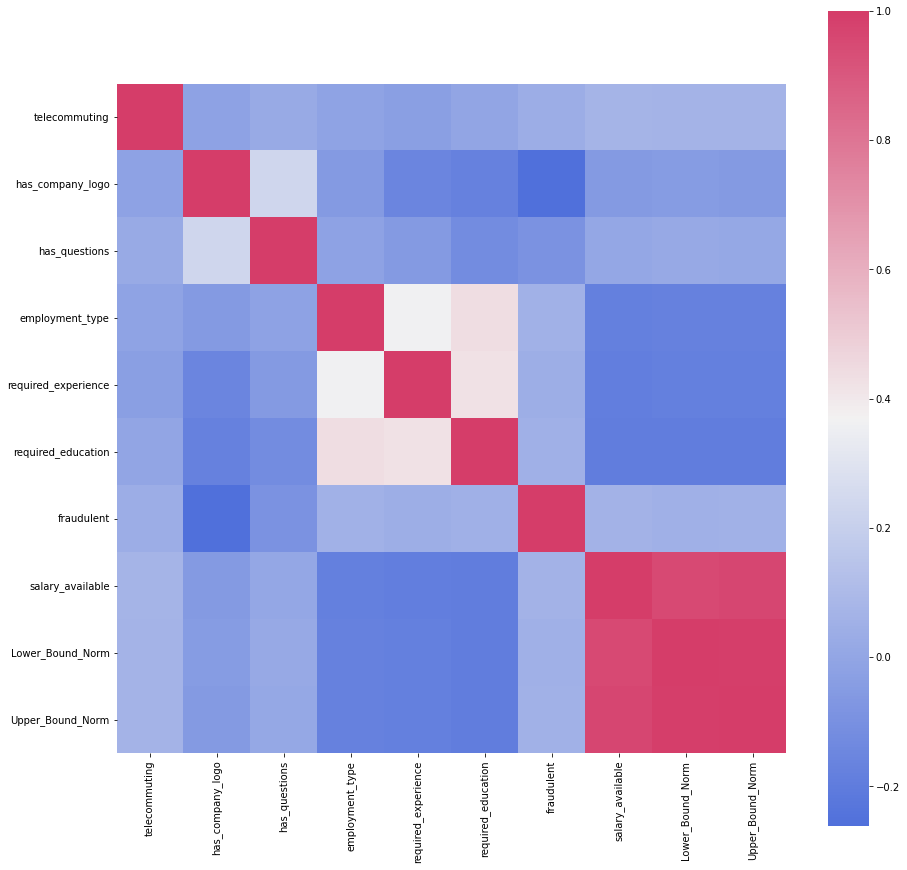

In [138]:
plt.figure(figsize = (15,15))
corr = df.corr()
sns.heatmap(corr, cmap=sns.diverging_palette(-100,0,as_cmap=True) , square = True)

#### Put text together

In [ ]:
df['text'] = df['title']+' '+df['department']+' '+df['Country']+' '+df['State']+' '+df['City'] +' '+\
             df_cat['has_company_logo']+' '+df_cat['has_questions']+' '+df_cat['salary_available']+' '+\
             df_cat['employment_type']+' '+df_cat['required_experience']+' '+df_cat['required_education']+' '+\
             df['industry']+' '+df['function']+' '+df['company_profile']+' '+df['description']+' '+df['requirements']+' '+df['benefits']

In [ ]:
df_text = df[['text','fraudulent']]
df_text.head()

,text,fraudulent
0,Marketing Intern Marketing US NY New York have...,Real
1,Customer Service - Cloud Video Production Succ...,Real
2,Commissioning Machinery Assistant (CMA) nodepa...,Real
3,Account Executive - Washington DC Sales US DC ...,Real
4,Bill Review Manager nodepartment US FL Fort Wo...,Real


In [ ]:
drop_cols = ['title', 'department', 'company_profile', 'description', 'requirements', 'benefits', 'industry','function','Country','State','City']
df = df.drop(drop_cols, axis = 1)
df.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,fraudulent,salary_available,Lower_Bound_Norm,Upper_Bound_Norm,text
0,0,1,0,2,4,13,Real,0,0.0,0.0,Marketing Intern Marketing US NY New York have...
1,0,1,0,1,6,13,Real,0,0.0,0.0,Customer Service - Cloud Video Production Succ...
2,0,1,0,5,7,13,Real,0,0.0,0.0,Commissioning Machinery Assistant (CMA) nodepa...
3,0,1,0,1,5,1,Real,0,0.0,0.0,Account Executive - Washington DC Sales US DC ...
4,0,1,1,1,5,1,Real,0,0.0,0.0,Bill Review Manager nodepartment US FL Fort Wo...


In [ ]:
df_train, df_test,Y_train,Y_test = train_test_split(df,df['fraudulent'], test_size = 0.25,random_state=16)
df_train.to_csv("/content/drive/My Drive/Real_Fake_Prediction_Cleaned_Train_2.csv",index=False)
df_test.to_csv("/content/drive/My Drive/Real_Fake_Prediction_Cleaned_Test_2.csv",index=False)

In [ ]:
df.to_csv("/content/drive/My Drive/Real_Fake_Prediction_Cleaned_511.csv",index=False)

## Text mining using spaCy pipeline, then using BERT

In [ ]:
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 12.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
from spacy.lang.en import English
import spacy
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# %%time
def clean_text(text):
  global ps,stopwords
  # Make text lowercase, remove text in square brackets,remove links,remove punctuation and remove words containing numbers.

  text = text.lower()
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n\r\t', '', text)
  text = re.sub('\w*\d\w*', '', text)
  text = re.sub(r'[/(){}\[\]\|@,;.:-]',' ',text)
  text = re.sub(r' {2,}',' ',text)
  return text


# Applying the cleaning function to both test and training datasets
df['text'] = df['text'].apply(lambda x: clean_text(x))
df['text'].head()

0    marketing intern marketing us ny new york have...
1    customer service cloud video production succes...
2    commissioning machinery assistant cma nodepart...
3    account executive washington dc sales us dc wa...
4    bill review manager nodepartment us fl fort wo...
Name: text, dtype: object

In [ ]:
nlp=spacy.load("en_core_web_sm")
df['text'] =df['text'].apply(lambda x: ' '.join([word for word in x.split() if nlp.vocab[word].is_stop==False ]))

In [ ]:
output=[]

for sentence in df['text']:
    sentence=nlp(str(sentence))
    s=[token.lemma_ for token in sentence]
    output.append(' '.join(s))
df['processed']=pd.Series(output)

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer


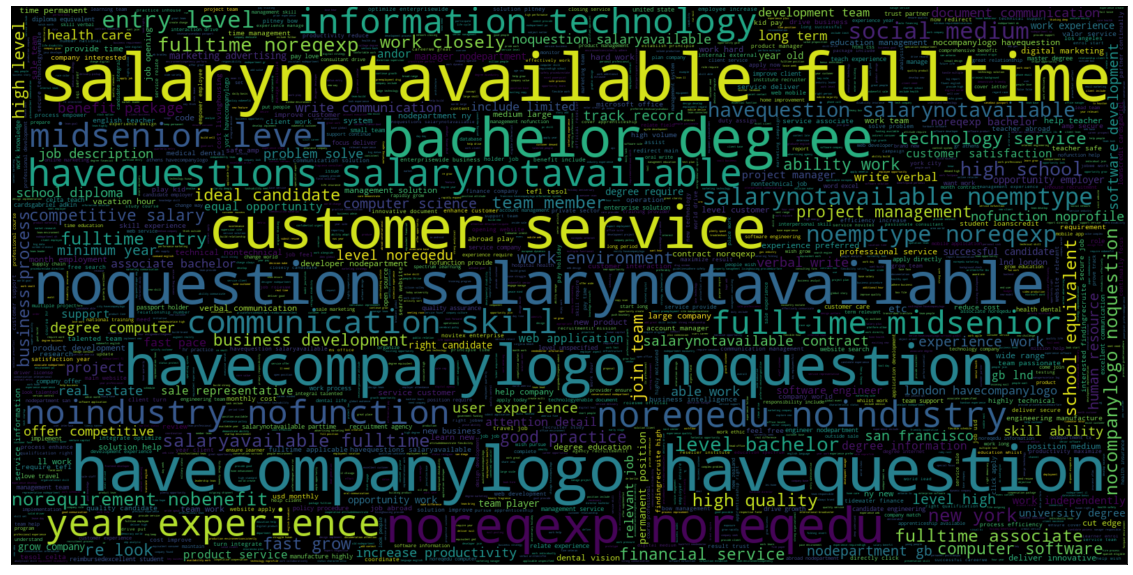

In [ ]:
cat_words = ['']
fig, ax = plt.subplots(figsize = (20,20)) # Text that is not fraudulent(0)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(' '.join(df[df.fraudulent == 0].processed))
plt.imshow(wc , interpolation = 'bilinear')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

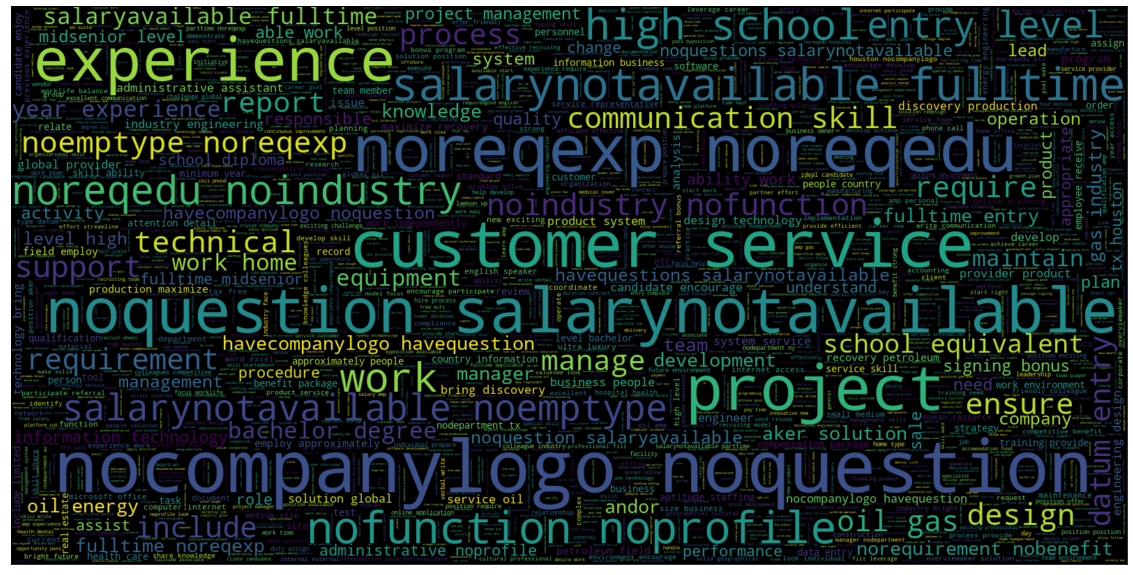

In [ ]:
fig, ax = plt.subplots(figsize = (20,20)) # Text that is fraudulent(1)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(' '.join(df[df.fraudulent == 1].processed))
plt.imshow(wc , interpolation = 'bilinear')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## Bidirectional LSTM

In [50]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [ ]:
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(df['processed'].values)
word_index = tokenizer.word_index
print(len(word_index))

150850


In [ ]:
X = tokenizer.texts_to_sequences(df['processed'].values)                         #Tokenize the dataset
X = pad_sequences(X, maxlen=200)     #Padding the dataset
# Y=df['fraudulent']                                                                   #Assign the value of y  
# print(Y.shape)
print(X.shape)

(17880, 200)


In [ ]:
X_train, X_test, df_train, df_test = train_test_split(X, df, test_size = 0.25,random_state=16)

In [ ]:
df_train.drop(['processed'], axis = 1).to_csv("/content/drive/My Drive/Real_Fake_Prediction_Cleaned_Train_1.csv",index=False)
df_test.drop(['processed'], axis = 1).to_csv("/content/drive/My Drive/Real_Fake_Prediction_Cleaned_Test_1.csv",index=False)

In [ ]:
X_train = np.array(X_train)
Y_train = np.array(df_train['fraudulent'])
X_test = np.array(X_test)
Y_test = np.array(df_test['fraudulent'])

In [151]:
from keras.layers import Embedding, SpatialDropout1D, Bidirectional, Dense, Input, Dropout
from keras import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 64)           6400000   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 200, 64)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              197632    
 nal)                                                            
                                                                 
 dense_18 (Dense)            (None, 32)                8224      
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                                 
Total params: 6,605,889
Trainable params: 6,605,889
No

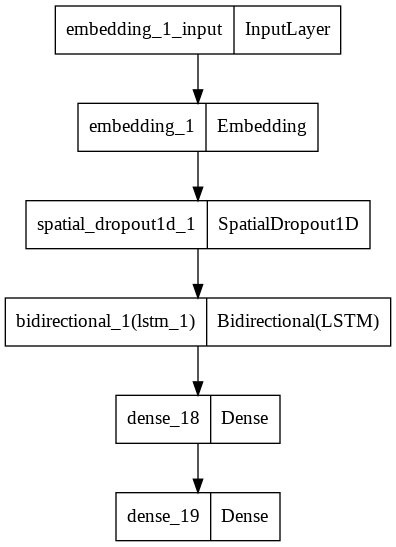

In [153]:
model = Sequential([
        Embedding(100000, 64, input_length=200),
        SpatialDropout1D(0.2), 
        Bidirectional(tf.keras.layers.LSTM(128)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
model.summary()
tf.keras.utils.plot_model(model)

In [107]:
# Set a learning rate annealer
es = EarlyStopping(
        monitor="val_accuracy", # metrics to monitor
        patience=3, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True # 
     )
rp = ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.2,
        patience=2,
        verbose=1,
        mode="max",
        min_lr=0.000001,
    )

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=30, batch_size=32, validation_split=0.2,callbacks=[es,rp], verbose=1)

Epoch 1/30
336/336 [==============================] - 189s 553ms/step - loss: 0.1540 - accuracy: 0.9622 - val_loss: 0.1263 - val_accuracy: 0.9661 - lr: 0.0010
Epoch 2/30
336/336 [==============================] - 160s 477ms/step - loss: 0.0545 - accuracy: 0.9835 - val_loss: 0.0947 - val_accuracy: 0.9691 - lr: 0.0010
Epoch 3/30
336/336 [==============================] - 175s 522ms/step - loss: 0.0226 - accuracy: 0.9927 - val_loss: 0.1376 - val_accuracy: 0.9746 - lr: 0.0010
Epoch 4/30
336/336 [==============================] - 154s 460ms/step - loss: 0.0062 - accuracy: 0.9986 - val_loss: 0.1263 - val_accuracy: 0.9698 - lr: 0.0010
Epoch 5/30
336/336 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 0.9995
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
336/336 [==============================] - 153s 455ms/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.1451 - val_accuracy: 0.9728 - lr: 0.0010
Epoch 6/30
336/336 [=======================

In [111]:
def plot_graphs(history, string):
  plt.figure(figsize = (10,7))
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()



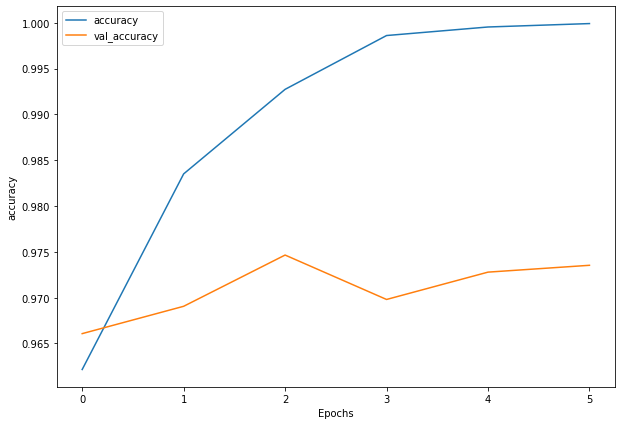

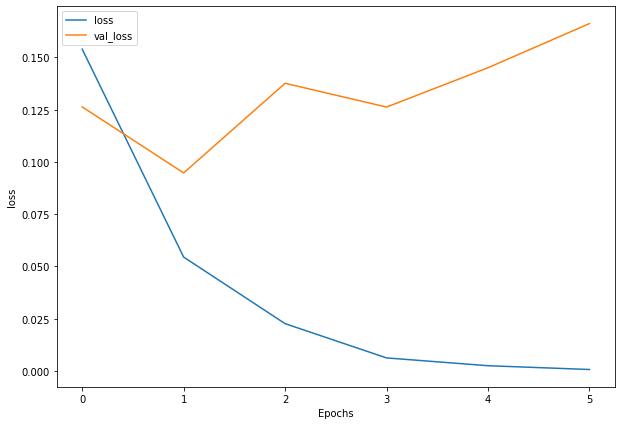

In [ ]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
from sklearn.metrics import confusion_matrix
Y_pred = np.around(model.predict(X_test), decimals = 0).flatten()
cf=confusion_matrix(Y_test,Y_pred)
# print(Y_pred.flatten())
cf

array([[4240,   11],
       [  77,  142]])

In [ ]:
answer = pd.Series(Y_pred,name="Bi_LSTM_Predict")
submission = pd.concat([df_test,answer],axis = 1)
submission.to_csv("/content/drive/My Drive/Bi_LSTM_Prediction.csv",index=False)

model.save(f"/content/drive/My Drive/Bi_LSTM_Model")

INFO:tensorflow:Assets written to: /content/drive/My Drive/Bi_LSTM_Model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Bi_LSTM_Model/assets


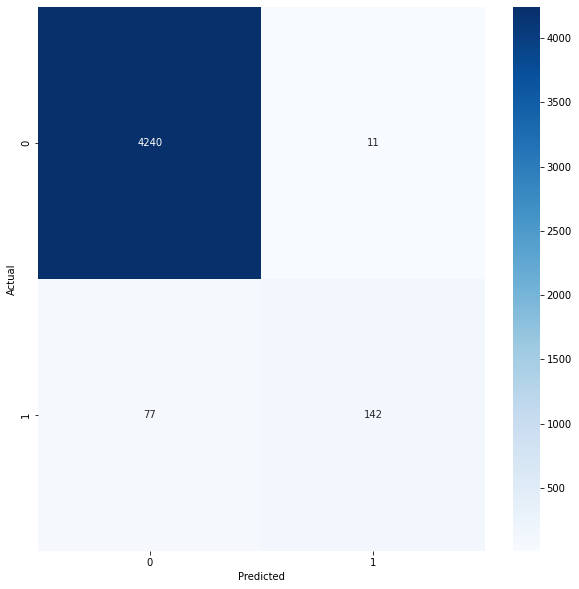

In [ ]:
cm = pd.DataFrame(cf, index=[0,1], columns=[0,1])
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues",annot = True, fmt='')

## BERT

In [79]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [72]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [85]:
import tensorflow_hub as hub
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
bert_layer = hub.KerasLayer(module_url, trainable=True)


In [101]:
df_train = pd.read_csv("/content/drive/My Drive/Real_Fake_Prediction_Cleaned_Train.csv")
df_test = pd.read_csv("/content/drive/My Drive/Real_Fake_Prediction_Cleaned_Test.csv")

In [102]:
X_train = df_train['text']
X_test = df_test['text']
Y_train = df_train['fraudulent']
Y_test = df_test['fraudulent']

In [ ]:
train_input = bert_encode(X_train.values, tokenizer, max_len=160)
test_input = bert_encode(X_test.values, tokenizer, max_len=160)
train_labels = Y_train.values

In [91]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')


BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [95]:
!pip install -q -U "tensorflow-text==2.8.*"
import tensorflow_text
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess,trainable=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 KB 24.7 MB/s eta 0:00:00


In [97]:
def build_classifier_model():
  text_input = Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = Dropout(0.1)(net)
  net = Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

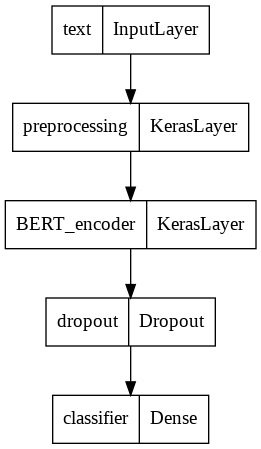

In [98]:
tf.keras.utils.plot_model(build_classifier_model())

In [99]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [109]:
classifier_model = build_classifier_model()
classifier_model.compile(optimizer=keras.optimizers.Adam(learning_rate=2e-6),loss=loss,metrics=metrics)
print(f'Training model with {tfhub_handle_encoder}')
# Set a learning rate annealer
es = EarlyStopping(
        monitor="val_binary_accuracy", # metrics to monitor
        patience=2, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True # 
     )
rp = ReduceLROnPlateau(
        monitor="val_binary_accuracy",
        factor=0.2,
        patience=1,
        verbose=1,
        mode="max",
        min_lr=0.0000001,
    )
history_bert = classifier_model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.2,callbacks=[es,rp], verbose=1)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/10
336/336 [==============================] - 2546s 8s/step - loss: 0.1732 - binary_accuracy: 0.9520 - val_loss: 0.1564 - val_binary_accuracy: 0.9508 - lr: 2.0000e-06
Epoch 2/10
336/336 [==============================] - ETA: 0s - loss: 0.1490 - binary_accuracy: 0.9519
Epoch 2: ReduceLROnPlateau reducing learning rate to 3.999999989900971e-07.
336/336 [==============================] - 2526s 8s/step - loss: 0.1490 - binary_accuracy: 0.9519 - val_loss: 0.1332 - val_binary_accuracy: 0.9508 - lr: 2.0000e-06
Epoch 3/10
336/336 [==============================] - ETA: 0s - loss: 0.1355 - binary_accuracy: 0.9524Restoring model weights from the end of the best epoch: 1.

Epoch 3: ReduceLROnPlateau reducing learning rate to 1e-07.
336/336 [==============================] - 2637s 8s/step - loss: 0.1355 - binary_accuracy: 0.9524 - val_loss: 0.1319 - val_binary_accuracy: 0.9508 - lr: 4.0000e-07
Epoc

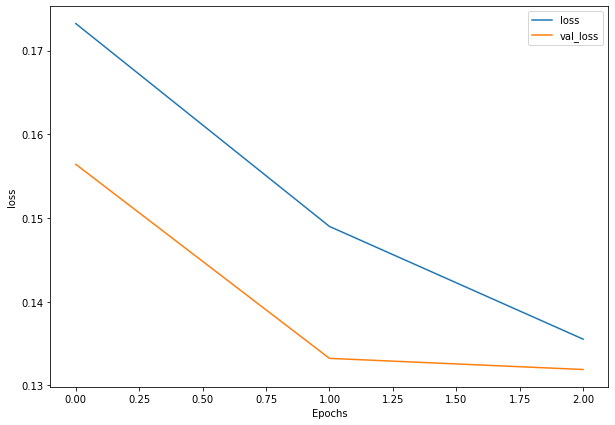

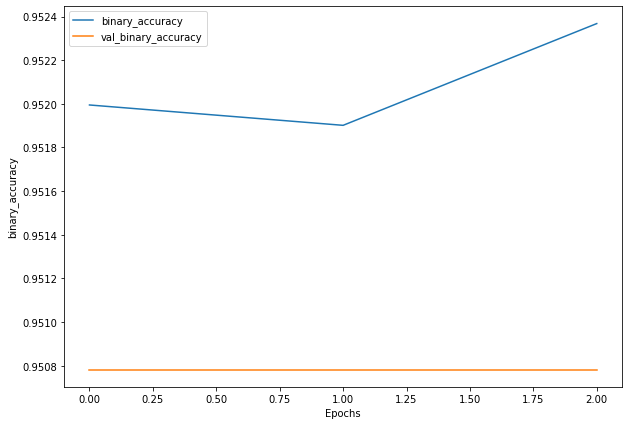

In [112]:
plot_graphs(history_bert, "loss")
plot_graphs(history_bert, "binary_accuracy")

In [113]:
Y_pred = np.around(classifier_model.predict(X_test), decimals = 0).flatten()
cf_bert=confusion_matrix(Y_test,Y_pred)
# print(Y_pred.flatten())
cf_bert

array([[   0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0],
       [  87, 1799, 1890,  425,   50,    0,    0],
       [   0,   10,   52,  109,   47,    1,    0]])

In [ ]:
answer_bert = pd.Series(Y_pred,name="BERT_Predict")
submission_bert = pd.concat([df_test,answer_bert],axis = 1)
submission_bert.to_csv("/content/drive/MyDrive/BERT_Prediction.csv",index=False)

model_bert.save(f"/content/drive/MyDrive/BERT_Model")

In [ ]:
cm_bert = pd.DataFrame(cf_bert, index=[0,1], columns=[0,1])
cm_bert.index.name = 'Actual'
cm_bert.columns.name = 'Predicted'

plt.figure(figsize = (10,10))
sns.heatmap(cm_bert,cmap= "Blues",annot = True, fmt='')

In [8]:
from sklearn.metrics import confusion_matrix
r_pred = pd.read_excel("/content/drive/MyDrive/predictions.xlsx")
Bi_pred = pd.read_csv("/content/drive/My Drive/Bi_LSTM_Prediction.csv")

In [24]:
Y_test = r_pred['Actual']
r_pred['Bi_LSTM_Predict'] = Bi_pred['Bi_LSTM_Predict']

In [29]:
r_pred['Best_3'] = r_pred['nb_prediction']+r_pred['rf_prediction']+r_pred['Bi_LSTM_Predict']
# print(r_pred['Best_3'].describe())
r_pred['Best_3'] = r_pred['Best_3'].apply(lambda x: int(x>1))
r_pred['Best_3'] = np.around(r_pred['Best_3'], decimals = 0)
print(r_pred['Best_3'].describe())
cf3 =confusion_matrix(Y_test,r_pred['Best_3'])
print(cf3)
print(f"Accuracy for Vote by NB, RF, Bi_LSTM: {(cf3[0][0]+cf3[1][1])/(cf3[0][0]+cf3[1][1]+cf3[0][1]+cf3[1][0])}")

count    4470.000000
mean        0.036242
std         0.186912
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Best_3, dtype: float64
[[4241   10]
 [  67  152]]
Accuracy for Vote by NB, RF, Bi_LSTM: 0.9827740492170023


In [43]:
r_pred['Best_5'] = r_pred['nb_prediction']+r_pred['rf_prediction']+r_pred['Bi_LSTM_Predict']+r_pred['knn_prediction']+r_pred['tree_prediction']
#print(r_pred['Best_5'].describe())
r_pred['Best_5'] = r_pred['Best_5'].apply(lambda x: int(x>2)) # To get sound system, decrease cutoff for vote, or add more voter; to get complete system, increase cutoff for vote
r_pred['Best_5'] = np.around(r_pred['Best_5'], decimals = 0)
print(r_pred['Best_5'].describe())
cf5 =confusion_matrix(Y_test,r_pred['Best_5'])
print(cf5)
print(f"Accuracy for Vote by NB, RF, Bi_LSTM, KNN, Tree: {(cf5[0][0]+cf5[1][1])/(cf5[0][0]+cf5[1][1]+cf5[0][1]+cf5[1][0])}")

count    4470.000000
mean        0.035794
std         0.185797
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Best_5, dtype: float64
[[4245    6]
 [  65  154]]
Accuracy for Vote by NB, RF, Bi_LSTM, KNN, Tree: 0.9841163310961969


In [44]:
r_pred['Sound'] = r_pred['nb_prediction']+r_pred['rf_prediction']+r_pred['Bi_LSTM_Predict']+r_pred['knn_prediction']+r_pred['tree_prediction']+r_pred['rules_prediction']
#print(r_pred['Sound'].describe())
r_pred['Sound'] = r_pred['Sound'].apply(lambda x: int(x>2))
r_pred['Sound'] = np.around(r_pred['Sound'], decimals = 0)
print(r_pred['Sound'].describe())
cfs =confusion_matrix(Y_test,r_pred['Sound'])
print(cfs)
print(f"Accuracy for Vote by NB, RF, Bi_LSTM, KNN, Tree: {(cfs[0][0]+cfs[1][1])/(cfs[0][0]+cfs[1][1]+cfs[0][1]+cfs[1][0])}")

count    4470.000000
mean        0.045190
std         0.207744
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Sound, dtype: float64
[[4218   33]
 [  50  169]]
Accuracy for Vote by NB, RF, Bi_LSTM, KNN, Tree: 0.9814317673378076
